# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import time
import xgboost as xgb
import seaborn as sns


from sklearn import preprocessing
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold,RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV,LinearRegression,Ridge,RidgeCV,LassoCV,Ridge,Lasso
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier,GradientBoostingClassifier,GradientBoostingRegressor
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix,r2_score,roc_curve,f1_score,\
mean_squared_error,roc_auc_score,recall_score,precision_score,make_scorer,precision_recall_curve
from lightgbm import LGBMRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')


In [2]:
data = pd.read_csv('/datasets/autos.csv')

In [3]:
def data_inform(data):
    print(80*"░")
    data.info()
    print(80*"░")
    print('Описание переменных:')
    print(data.describe())
    print(80*"░")
    print(f'Кол-во дубликатов: {data.duplicated().sum()}')

In [4]:
data_inform(data)

░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null 

In [5]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


В данных много пропусков. Если полностью удалить объекты с пропусками, которые нельзя восстановить на основе других параметров, т.к. они категориальные, возможно, потеряем существенную часть информации. Поэтому заполним пропущенные значения нулями. 

In [6]:
data["VehicleType"] = data["VehicleType"].fillna(data["VehicleType"].mode().values[0])
data["Gearbox"] = data["Gearbox"].fillna(data["Gearbox"].mode().values[0])
data["Model"] = data["Model"].fillna(data["Model"].mode().values[0])
data["FuelType"] = data["FuelType"].fillna(data["FuelType"].mode().values[0])

data["NotRepaired"] = data["NotRepaired"].fillna("no")

In [7]:
data.duplicated().sum()

5

In [8]:
data = data.drop_duplicates()
data.duplicated().sum()

0

In [9]:
#Избавимся от ненужных столбцов 
data = data.drop(["DateCrawled","DateCreated","LastSeen","NumberOfPictures","PostalCode"],axis = 1)

In [10]:
#Установим реалистичные границы Year
def year_norm(value):
    if value > 2016:
        return 2016
    elif value < 1930:
        return 1930
    else:
        return value
data['RegistrationYear'] = data['RegistrationYear'].apply(year_norm)

#Установим реалистичные границы RegistrationMonth
data.loc[data['RegistrationMonth'] == 0, 'RegistrationMonth'] = 1

#Установим реалистичные границы Power
data.loc[data['Power'] > 3500, 'Power'] = 3500

In [11]:
#Избавимся от выбросов
def sieve (data, column):
    q25 = np.array(data[column].quantile(0.25))
    q75 = np.array(data[column].quantile(0.75))
    first_part = q25-1.5*(q75-q25)
    second_part = q75+1.5*(q75-q25)
    del_index = []
    
    for index_value, value in zip(data[column].index, data[column]):
        if second_part <= value or value <= first_part:
            del_index.append(index_value)
    
    print('Cтрок для удаления ' + str(column)+":", len(del_index))
    return del_index

In [12]:
array_col = ["Price","Power"]
count = 0 
for column in array_col:
    index_del = sieve(data, column)
    count += len(index_del)
    frame = data.drop(index_del, axis = 0)
print("Удалено:", count)

Cтрок для удаления Price: 18979
Cтрок для удаления Power: 7367
Удалено: 26346


In [13]:
corr = data.corr()

Проведена работа с данными. Очистил от выбросов, удалил дубликаты, поставил разумные границы для 'RegistrationYear', 'RegistrationMonth', 'Power'. В таблице появилось множество дубликатов, но это простое совпадение данных, т.к. были изменены значения почти в четверти данных и приведены к разумным границам.

Проведем более детальную проверку на выявление выбросов

<AxesSubplot:>

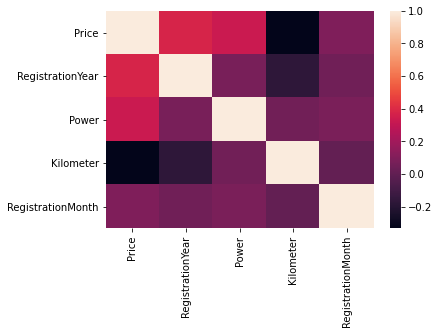

In [14]:
sns.heatmap(corr)

In [15]:
new_df = data[['VehicleType', 
                         'Gearbox', 
                         'Power',
                         'Kilometer',
                         'FuelType',
                         'Brand',
                         'NotRepaired',
                         'RegistrationYear',
                         'Model',
                         'Price']]

In [16]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354364 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       354364 non-null  object
 1   Gearbox           354364 non-null  object
 2   Power             354364 non-null  int64 
 3   Kilometer         354364 non-null  int64 
 4   FuelType          354364 non-null  object
 5   Brand             354364 non-null  object
 6   NotRepaired       354364 non-null  object
 7   RegistrationYear  354364 non-null  int64 
 8   Model             354364 non-null  object
 9   Price             354364 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 37.8+ MB


In [17]:
# функция для вызова проверки квантилей и графика по столбцам
def check_columns(columns):
    columns.hist(bins=100, figsize=(12,10))
    display(columns.describe())

In [18]:
#распределение целевого признака Price
new_df['Price'].value_counts()

0        10772
500       5670
1500      5394
1000      4648
1200      4594
         ...  
13180        1
10879        1
2683         1
634          1
8188         1
Name: Price, Length: 3731, dtype: int64

Более 10000 автомобилей отдаются бесплатно, избавимся от этих данных.

count    343592.000000
mean       4555.122785
std        4515.059785
min           1.000000
25%        1200.000000
50%        2890.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64

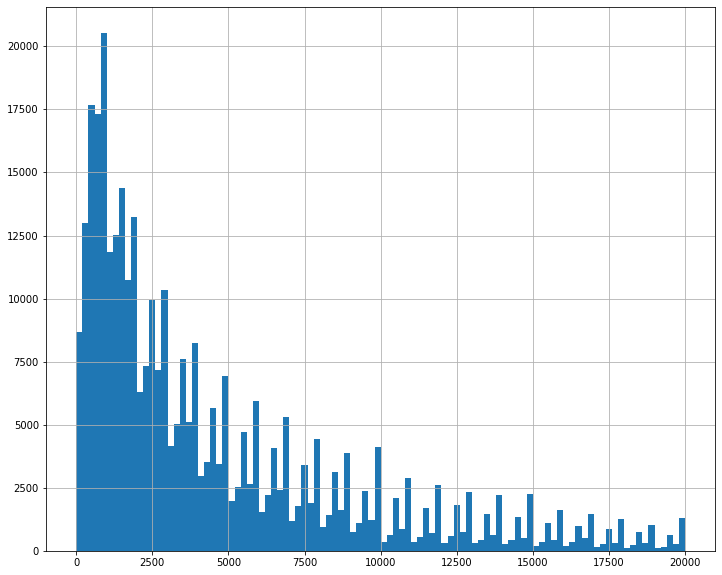

In [19]:
new_df = new_df.query('Price > 0')
check_columns(new_df['Price'])

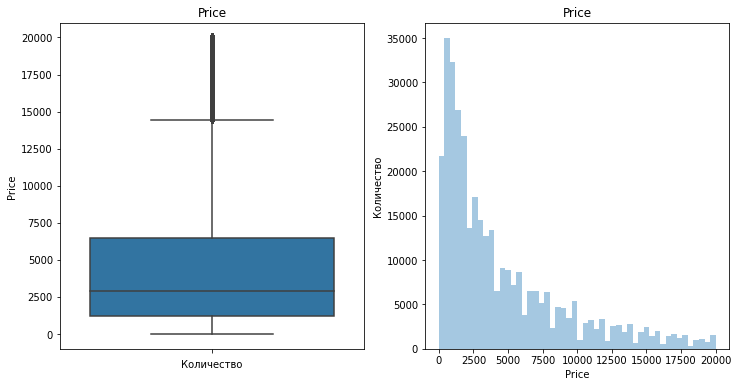

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].set_title('Price')
sns.boxplot(y = 'Price', data=new_df, ax = axes[0])
axes[0].set_xlabel('Количество')
     
axes[1].set_title('Price')
sns.distplot(new_df['Price'], kde=False, bins=50, ax = axes[1])
axes[1].set_ylabel('Количество')
            
plt.show()

In [21]:
new_df = new_df.query('350 <= Price <= 14450')
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 309116 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       309116 non-null  object
 1   Gearbox           309116 non-null  object
 2   Power             309116 non-null  int64 
 3   Kilometer         309116 non-null  int64 
 4   FuelType          309116 non-null  object
 5   Brand             309116 non-null  object
 6   NotRepaired       309116 non-null  object
 7   RegistrationYear  309116 non-null  int64 
 8   Model             309116 non-null  object
 9   Price             309116 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 25.9+ MB


count    309116.000000
mean        107.767003
std          88.828385
min           0.000000
25%          71.000000
50%         105.000000
75%         140.000000
max        3500.000000
Name: Power, dtype: float64

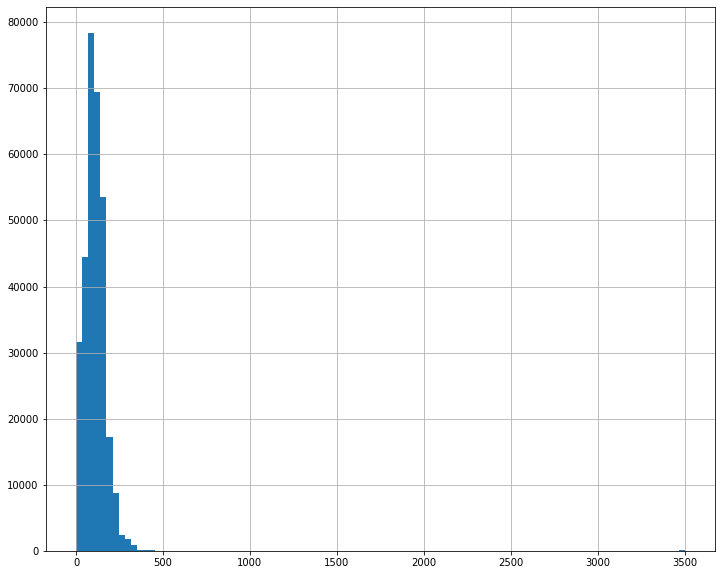

In [22]:
check_columns(new_df['Power'])

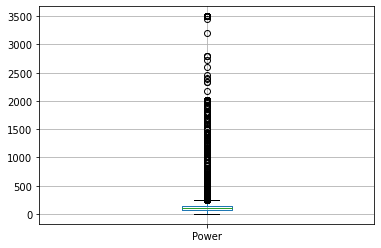

In [23]:
new_df.boxplot(column='Power')
plt.show()

count    278325.000000
mean        117.662280
std          51.180725
min           1.000000
25%          75.000000
50%         109.000000
75%         143.000000
max        1000.000000
Name: Power, dtype: float64

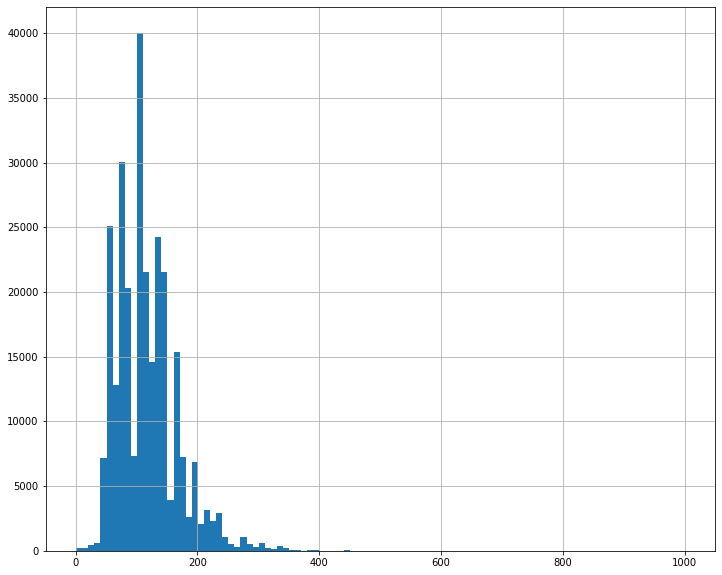

In [24]:
#Посмотрим как изменится информативность графика, если отсечь выбросы
new_df = new_df.query('0 < Power < 1001')
check_columns(new_df['Power'])

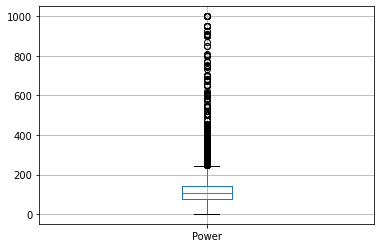

In [25]:
new_df.boxplot(column='Power')
plt.show()

В основном, остались автомобили с мощностью до 250 л.с. Избавлюсь от выбросов

count    273192.000000
mean        114.596310
std          43.989627
min          26.000000
25%          75.000000
50%         109.000000
75%         143.000000
max         250.000000
Name: Power, dtype: float64

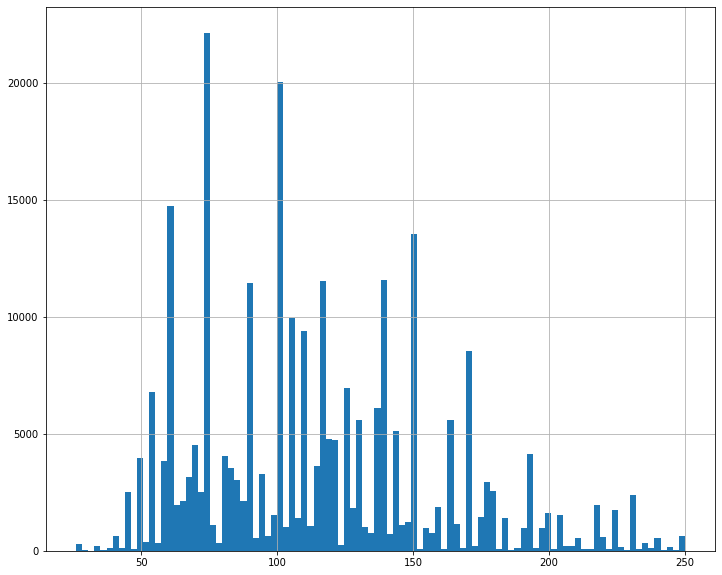

In [26]:
new_df = new_df.query('25 < Power <= 250')
check_columns(new_df['Power'])

count    273192.000000
mean       2003.086672
std           6.580090
min        1930.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

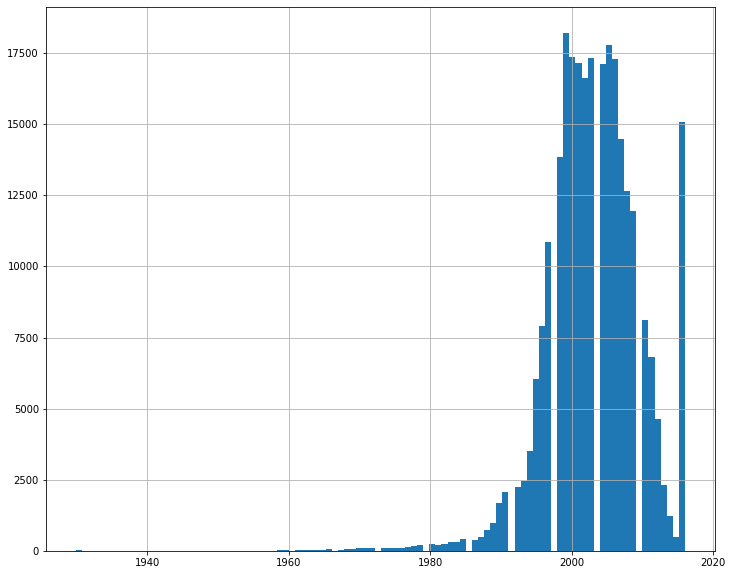

In [27]:
check_columns(new_df['RegistrationYear'])

Предыдущая обработка внесла уже достаточные изменения в данные для их корректности.

count    273192.000000
mean     130408.503909
std       34795.778261
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

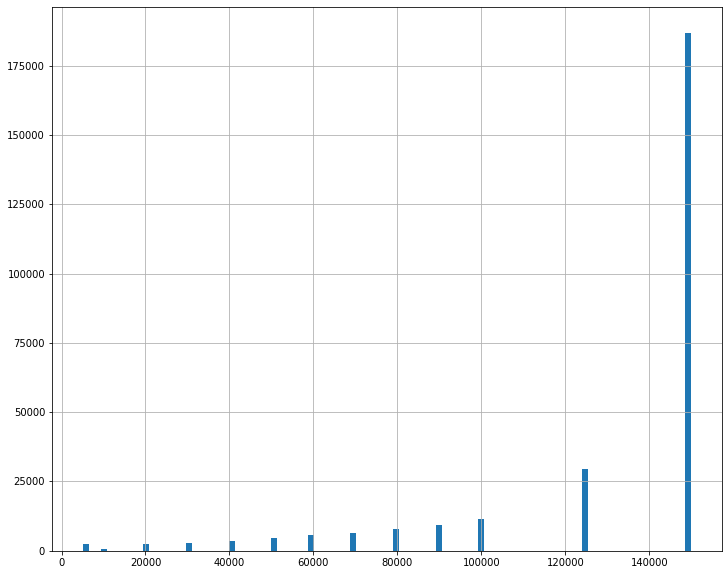

In [28]:
check_columns(new_df['Kilometer'])

Т.к. уникальных значений мало, и максимальный пробег 150тыс. км., можно предположить, что у сайта не было возможности предоставить составителю анкеты точно указывать пробег. И все авто с пробегом больше 150тыс км, указывались как 150тыс+

In [29]:
new_df['IsManualGearbox'] = 0
new_df.loc[new_df['Gearbox'] == 'manual', 'IsManualGearbox'] = 1
display(new_df['IsManualGearbox'].value_counts())
new_df['Gearbox'].value_counts()

1    225467
0     47725
Name: IsManualGearbox, dtype: int64

manual    225467
auto       47725
Name: Gearbox, dtype: int64

In [30]:
new_df['IsNotRepaired'] = 0
new_df.loc[new_df['NotRepaired'] == 'yes', 'IsNotRepaired'] = 1
display(new_df['IsNotRepaired'].value_counts())
new_df['NotRepaired'].value_counts()

0    248087
1     25105
Name: IsNotRepaired, dtype: int64

no     248087
yes     25105
Name: NotRepaired, dtype: int64

In [31]:
#Изменим размерность хранения типа данных для ускорения
new_df.drop(['NotRepaired','Gearbox'], inplace=True, axis=1)
new_df['IsNotRepaired'] = pd.to_numeric(new_df['IsNotRepaired'], downcast='integer')
new_df['IsManualGearbox'] = pd.to_numeric(new_df['IsManualGearbox'], downcast='integer')
new_df['RegistrationYear'] = pd.to_numeric(new_df['RegistrationYear'], downcast='integer')
new_df['Power'] = pd.to_numeric(new_df['Power'], downcast='integer')
new_df['Kilometer'] = pd.to_numeric(new_df['Kilometer'], downcast='integer')
new_df['Price'] = pd.to_numeric(new_df['Price'], downcast='integer')
new_df.info()
display(new_df.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 273192 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       273192 non-null  object
 1   Power             273192 non-null  int16 
 2   Kilometer         273192 non-null  int32 
 3   FuelType          273192 non-null  object
 4   Brand             273192 non-null  object
 5   RegistrationYear  273192 non-null  int16 
 6   Model             273192 non-null  object
 7   Price             273192 non-null  int16 
 8   IsManualGearbox   273192 non-null  int8  
 9   IsNotRepaired     273192 non-null  int8  
dtypes: int16(3), int32(1), int8(2), object(4)
memory usage: 13.5+ MB


(273192, 10)

## Обучение моделей

In [32]:
# неизмененные признаки
original_features = new_df.drop('Price', axis=1)

# целевой признак
target = new_df['Price']

In [33]:
# cat_columns = ['VehicleType','FuelType','Brand','Model']
# num_columns = new_df.drop(['VehicleType','FuelType','Brand','Model'], axis=1)

# #Прямое кодирование
# encoder = OrdinalEncoder()

# cat_features = original_features[cat_columns]
# cat_features = pd.DataFrame(encoder.fit_transform(cat_features),
#                                 columns=cat_features.columns, 
#                                 index=cat_features.index)
# ordinal_features = original_features.copy()
# for column in cat_columns:
#     ordinal_features[column] = cat_features[column]
    

# #OHE кодирование
# ohe_features = pd.get_dummies(original_features, drop_first=True)

# original_features_train, original_features_test, target_train, target_test = train_test_split(
#     original_features, target, test_size=0.25, random_state=12345)

# ordinal_features_train = ordinal_features.loc[original_features_train.index, :]
# ordinal_features_test = ordinal_features.loc[original_features_test.index, :]

# ohe_features_train = ohe_features.loc[original_features_train.index, :]
# ohe_features_test = ohe_features.loc[original_features_test.index, :]


In [34]:
features_train, features_test, target_train, target_test = train_test_split(
    original_features, target, test_size=0.25, random_state=12345
)

cat_columns = ['VehicleType', 'Model', 'FuelType', 'Brand']
num_columns = ['RegistrationYear', 'Power', 'Kilometer']

encoder = OneHotEncoder(handle_unknown='ignore')

ohe_features_train = pd.DataFrame(
    encoder.fit_transform(features_train[cat_columns]).toarray(),
    columns=encoder.get_feature_names(),
    index=features_train.index
)

ohe_features_test = pd.DataFrame(
    encoder.fit_transform(features_test[cat_columns]).toarray(),
    columns=encoder.get_feature_names(),
    index=features_test.index
)

scaler = StandardScaler(with_mean=False)

features_train_numeric = pd.DataFrame(
    scaler.fit_transform(features_train[num_columns]), 
    columns=num_columns,
    index=features_train.index
)

features_test_numeric = pd.DataFrame(
    scaler.fit_transform(features_test[num_columns]), 
    columns=num_columns,
    index=features_test.index
)

ohe_features_train= ohe_features_train.join(features_train_numeric)
ohe_features_test= ohe_features_test.join(features_test_numeric)

encoder_ord = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)

features_train_ord = features_train.copy()
features_train_ord[cat_columns] = encoder_ord.fit_transform(features_train[cat_columns])
features_train_ord = features_train_ord.dropna()
target_train_ord = target_train.copy()

features_test_ord = features_test.copy()
features_test_ord[cat_columns] = encoder_ord.transform(features_test[cat_columns])
features_test_ord = features_test_ord.dropna()
target_test_ord = target_test[features_test_ord.index]

In [36]:
start = time.time()

regressor_lr_m = LinearRegression()
scaller = StandardScaler()
pipeline = Pipeline([("normalize", scaller),("linear_regression", regressor_lr_m)])
print('# Обучение для neg_root_mean_squared_error')
print()
cv_RMSE_LR_S = (cross_val_score(pipeline,
                                 features_train_ord, 
                                 target_train, 
                                 cv=5, 
                                 scoring='neg_root_mean_squared_error').mean() * -1)
print('Mean RMSE from CV of LinearRegression =', cv_RMSE_LR_S)

end = time.time()
regressor_lr_m_time_train = end - start
print('Время обучения модели:', regressor_lr_m_time_train)

# Обучение для neg_root_mean_squared_error

Mean RMSE from CV of LinearRegression = 2367.7156346977386
Время обучения модели: 0.9705991744995117


In [37]:
start = time.time()
regressor_lr_m.fit(ohe_features_train, target_train)
lr_predict_m = regressor_lr_m.predict(ohe_features_train)
end = time.time()
lr_predict_m_time = end - start
print('Время предсказания и обучения модели:', lr_predict_m_time)

Время предсказания и обучения модели: 38.0838098526001


In [38]:
# start = time.time()

# model_rf = RandomForestRegressor(random_state=12345, criterion='mse', warm_start=False)
# n_estimators = (2, 8, 10)
# hyperparams = [{'max_depth':n_estimators}]



# print('# Tuning hyper-parameters for root_mean_squared_error')
# print()
# clf = GridSearchCV(model_rf, hyperparams, scoring='neg_mean_squared_error')
# clf.fit(ohe_features_train, target_train)
# end = time.time()
# print("Best parameters set found on development set:")
# print()
# print(clf.best_params_)
# print()
# print("Grid scores on development set:")
# print()
# means = clf.cv_results_['mean_test_score']
# stds = clf.cv_results_['std_test_score']
# for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#     print("%0.6f for %r"% ((mean*-1)** 0.5, params))
# print()

# cv_RMSE_R = (max(means)*-1) ** 0.5


In [39]:
#DecisionTreeRegressor


regressor_dtr = DecisionTreeRegressor(criterion='mse', random_state=12345) 
max_depth_list = [x for x in range(2, 31)]
hyperparams = [{'max_depth':max_depth_list}]

print('# Tuning hyper-parameters for root_mean_squared_error')
print()
clf = GridSearchCV(regressor_dtr, hyperparams, scoring='neg_mean_squared_error')
start = time.time()
clf.fit(features_train_ord, target_train)
end = time.time()
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_DTR_ordinal = (max(means)*-1) ** 0.5


regressor_dtr_time_train = end - start
print('Время побора гиперпараметров модели:', regressor_dtr_time_train) 

# Tuning hyper-parameters for root_mean_squared_error

Best parameters set found on development set:

{'max_depth': 15}

Grid scores on development set:

2549.024686 for {'max_depth': 2}
2346.870250 for {'max_depth': 3}
2138.798539 for {'max_depth': 4}
1996.208158 for {'max_depth': 5}
1867.377752 for {'max_depth': 6}
1776.183661 for {'max_depth': 7}
1710.406225 for {'max_depth': 8}
1653.727046 for {'max_depth': 9}
1612.151937 for {'max_depth': 10}
1571.428866 for {'max_depth': 11}
1546.470177 for {'max_depth': 12}
1530.501769 for {'max_depth': 13}
1520.336539 for {'max_depth': 14}
1516.185531 for {'max_depth': 15}
1516.659973 for {'max_depth': 16}
1522.796449 for {'max_depth': 17}
1532.572846 for {'max_depth': 18}
1541.850369 for {'max_depth': 19}
1551.688106 for {'max_depth': 20}
1555.476641 for {'max_depth': 21}
1561.971426 for {'max_depth': 22}
1566.626913 for {'max_depth': 23}
1568.231357 for {'max_depth': 24}
1569.416808 for {'max_depth': 25}
1570.734815 for {'max_depth': 26}
1570

In [40]:
start = time.time()

regressor_dtr_predict = clf.predict(features_train_ord)
end = time.time()
regressor_dtr_time_predict = end - start
print('Время предсказания модели:', regressor_dtr_time_predict)

Время предсказания модели: 0.04285287857055664


Обучение на порядковом кодировании признаков дало практически такой же результат, что и обучение на OHE.

In [41]:
#CatBoostRegressor OE
#И на оригинальных данных с указанием категорий
start = time.time()

regressor_cbr = CatBoostRegressor() 
hyperparams = [{'learning_rate':[0.1, 0.5, 0.8],
                'random_state':[12345],
                'verbose':[False]}]

print('# Tuning hyper-parameters for root_mean_squared_error')
print()
clf = GridSearchCV(regressor_cbr, hyperparams, scoring='neg_mean_squared_error')
clf.fit(features_train_ord, target_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_CBR_ordinal = (max(means)*-1) ** 0.5

end = time.time()
regressor_cbr_time_train = end - start

print('Время обучения модели:', regressor_cbr_time_train) 

# Tuning hyper-parameters for root_mean_squared_error

Best parameters set found on development set:

{'learning_rate': 0.5, 'random_state': 12345, 'verbose': False}

Grid scores on development set:

1318.563225 for {'learning_rate': 0.1, 'random_state': 12345, 'verbose': False}
1289.740664 for {'learning_rate': 0.5, 'random_state': 12345, 'verbose': False}
1309.217302 for {'learning_rate': 0.8, 'random_state': 12345, 'verbose': False}

Время обучения модели: 384.4714460372925


In [42]:
start = time.time()

regressor_cbr_predict = clf.predict(features_train_ord)
end = time.time()
regressor_cbr_time_predict = end - start
print('Время предсказания модели:', regressor_cbr_time_predict)

Время предсказания модели: 0.19616460800170898


In [43]:
start = time.time()

regressor_cbr_original = CatBoostRegressor(learning_rate=0.5,
                              iterations = 200,
                              random_state=12345, 
                              verbose=False, 
                              cat_features=['VehicleType','FuelType','Brand','Model']) 
print('# Train for root_mean_squared_error')
print()
cv_RMSE_CBR_original = (cross_val_score(regressor_cbr_original,
                                features_train, 
                                target_train, 
                                cv=5, 
                                scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Mean RMSE from CV of CatBoostRegressor =', cv_RMSE_CBR_original)

end = time.time()
regressor_cbr_original_time_train = end - start
print('Время обучения модели:', regressor_cbr_original_time_train)

# Train for root_mean_squared_error

Mean RMSE from CV of CatBoostRegressor = 1331.4877212693805
Время обучения модели: 122.91606974601746


In [44]:
start = time.time()
regressor_cbr_original.fit(features_train, target_train)
regressor_cbr_original_predict = regressor_cbr_original.predict(features_train)

end = time.time()
regressor_cbr_original_time_predict = end - start
print('Время предсказания модели:', regressor_cbr_original_time_predict)

Время предсказания модели: 33.58401584625244


In [45]:
#LGBMRegressor
start = time.time()

regressor_lgbm = LGBMRegressor() 
hyperparams = [{'num_leaves':[31, 100, 200], 
                'learning_rate':[0.1, 0.3, 0.5],
                'random_state':[12345]}]

print('# Tuning hyper-parameters for root_mean_squared_error')
print()
clf = GridSearchCV(regressor_lgbm, hyperparams, scoring='neg_mean_squared_error')
clf.fit(features_train_ord, target_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_LGBMR = (max(means)*-1) ** 0.5

end = time.time()
regressor_lgbm_time_train = end - start
print('Время обучения модели:', regressor_lgbm_time_train)

# Tuning hyper-parameters for root_mean_squared_error

Best parameters set found on development set:

{'learning_rate': 0.3, 'num_leaves': 200, 'random_state': 12345}

Grid scores on development set:

1388.316196 for {'learning_rate': 0.1, 'num_leaves': 31, 'random_state': 12345}
1321.862496 for {'learning_rate': 0.1, 'num_leaves': 100, 'random_state': 12345}
1294.473898 for {'learning_rate': 0.1, 'num_leaves': 200, 'random_state': 12345}
1336.561789 for {'learning_rate': 0.3, 'num_leaves': 31, 'random_state': 12345}
1295.056360 for {'learning_rate': 0.3, 'num_leaves': 100, 'random_state': 12345}
1281.988425 for {'learning_rate': 0.3, 'num_leaves': 200, 'random_state': 12345}
1328.315428 for {'learning_rate': 0.5, 'num_leaves': 31, 'random_state': 12345}
1305.269499 for {'learning_rate': 0.5, 'num_leaves': 100, 'random_state': 12345}
1303.275201 for {'learning_rate': 0.5, 'num_leaves': 200, 'random_state': 12345}

Время обучения модели: 7295.239015340805


In [46]:
start = time.time()

regressor_lgbm_predict = clf.predict(features_train_ord)

end = time.time()
regressor_lgbm_time_predict = end - start
print('Время предсказания модели:', regressor_lgbm_time_predict)

Время предсказания модели: 1.70768141746521


## Анализ моделей

In [53]:
index = ['LinearRegression',
         'DecisionTreeRegressor on OE features',
         'CatBoostRegressor on OE features',
         'CatBoostRegressor on original features',
         'LGBMRegressor']
data = {'RMSE на CV, евро':[cv_RMSE_LR_S,
                            cv_RMSE_DTR_ordinal,
                            cv_RMSE_CBR_ordinal,
                            cv_RMSE_CBR_original,
                            cv_RMSE_LGBMR],
        'Время обучения на CV, сек':[regressor_lr_m_time_train,
                                     regressor_dtr_time_train,
                                     regressor_cbr_time_train,
                                     regressor_cbr_original_time_train,
                                     regressor_lgbm_time_train],
        'Время предсказания модели, сек':[lr_predict_m_time,
                                          regressor_dtr_time_predict,
                                          regressor_cbr_time_predict,
                                          regressor_cbr_original_time_predict,
                                          regressor_lgbm_time_predict]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data['Общее время, сек'] = (scores_data['Время обучения на CV, сек'] + 
                                               scores_data['Время предсказания модели, сек'])
scores_data

,"RMSE на CV, евро","Время обучения на CV, сек","Время предсказания модели, сек","Общее время, сек"
LinearRegression,2367.715635,0.970599,38.083810,39.054409
DecisionTreeRegressor on OE features,1516.185531,59.987605,0.042853,60.030457
CatBoostRegressor on OE features,1289.740664,384.471446,0.196165,384.667611
CatBoostRegressor on original features,1331.487721,122.916070,33.584016,156.500086
LGBMRegressor,1281.988425,7295.239015,1.707681,7296.946697


По таблице видно, что лучшим по показателям является CatBoostRegressor, причем на исходных данных. Точность выше у LGBMRegressor, но время выполнения в разы выше. Протестируем на тестовой выборке CatBoostRegressor.

In [55]:
%%time

model = CatBoostRegressor(learning_rate=0.5, 
                          iterations = 200, 
                          random_state=12345, 
                          verbose=False,
                          cat_features=['VehicleType','FuelType','Brand','Model']) 
model.fit(features_train, target_train)

CPU times: user 31.2 s, sys: 140 ms, total: 31.4 s
Wall time: 32 s


In [ ]:
target_predict = model.predict(original_features_test)
final_RMSE_CBR_original = mean_squared_error(target_test, target_predict) ** 0.5
final_RMSE_CBR_original

## Вывод
В ходе работы я провел анализ и предобработку данных, сравнил модели с разными гиперпараметрами и выбрал лучшую по метрике RMSE и времени обучения - CatBoostRegressor

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей